<a href="https://colab.research.google.com/github/Gusa01/CoderHouse_Spotify-Project/blob/main/Storytelling_Castromil_Agust%C3%ADn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from   scipy import stats

In [ ]:
path = 'https://drive.google.com/uc?id=1Cr-pBy78hWeAfoDqmO1wPhoqjwOsTn6M'
pd.set_option('display.max_columns', 50)
df = pd.read_csv(path, encoding= 'unicode_escape')

# Limpieza y modificación del df

In [ ]:
df_normalized = df.copy()

In [ ]:
df_normalized = df_normalized.drop_duplicates(subset=['instance_id'], keep='first')

In [ ]:
df_normalized.speechiness = df_normalized.speechiness.astype(float)

In [ ]:
df_normalized.tempo = df_normalized['tempo'].replace('?', np.NaN)
df_normalized.tempo = df_normalized['tempo'].replace('<', np.NaN)
df_normalized.tempo = df_normalized.tempo.fillna(0).astype(float)
df_normalized = df_normalized.drop(index=df_normalized[df_normalized['tempo'] == 0].index, axis=0)
df_normalized = df_normalized.dropna(subset=['tempo'])
df_normalized.tempo = df_normalized.tempo.astype(float)

In [ ]:
df_normalized = df_normalized.applymap(lambda x: x.encode('iso-8859-1').decode('utf-8') if isinstance(x, str) else x)
df_norma_sample = df_normalized.sample(2000)

In [ ]:
# Creación de columna categorica para agrupar según tempo
bins = [0, 60, 66, 76, 108, 120, 168, 200, 216]
labels = ['Lento', 'Larghetto', 'Adagio', 'Andante', 'Moderato', 'Allegro', 'Presto', 'Prestissimo']
df_normalized['tempo_type'] = pd.cut(df_normalized['tempo'], bins=bins, labels=labels)

In [ ]:
# Eliminamos columnas que no usaremos para entrenar el modelo
df_normalized = df_normalized.drop(['artist_name', 'obtained_date', 'track_name', 'instance_id'], axis= 1)

In [ ]:
# Función para remover outliers utilizando el método IQR
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    df = df[(df[column_name] > lower_limit) & (df[column_name] < upper_limit)]
    return df

In [ ]:
cols = ['acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence']

for col in cols:
  remove_outliers(df_normalized, col)

# Objetivo y problema comercial

Hoy en día, en pleno 2023, sacar una canción y darle a las personas la posibilidad de que la escuchen, es algo mucho más simple a comparación de hace 30 años. En gran parte, esto se debe gracias a plataformas como Spotify, no solo por el fácil acceso que brinda a cualquier tipo de contenido auditivo, ya sean canciones o podcasts, sino también por el gran tráfico de personas que maneja. Aun así y con todo esto, no siempre es tan fácil que las canciones logren el nivel de popularidad que a sus creadores les gustaría. Y la realidad es que a que artista no le gustaría saber si su tema tendrá éxito, ¿valdrá la pena todo el tiempo y dinero invertidos? Mi objetivo es desarrollar una solución resuelva esta inquietud.

Para lograr esto la idea es, mediante una serie de datos extraídos de Spotify, poder predecir la popularidad de las canciones, teniendo en cuenta caracteísticas como su nota dominante, su bailabilidad, au energía, que tan ruidosa es, su tempo, etc.

Pero para esta primera parte realizaremos mediante gráficos bidimensionales y unidimensionales, es decir, analizando una única variable o  relacionando 2 variables del dataset, un primer acercamiento a los datos, conociendolos un poco y pudiendonos responder ciertas preguntas las cuales iré comentando más adelante. Este proceso se lo conoce como Exploratory Data Analysis (EDA) y lo iniciaremos viendo los siguientes gráficos:

# EDA

Text(0.5, 1.0, 'Energy x Popularity')

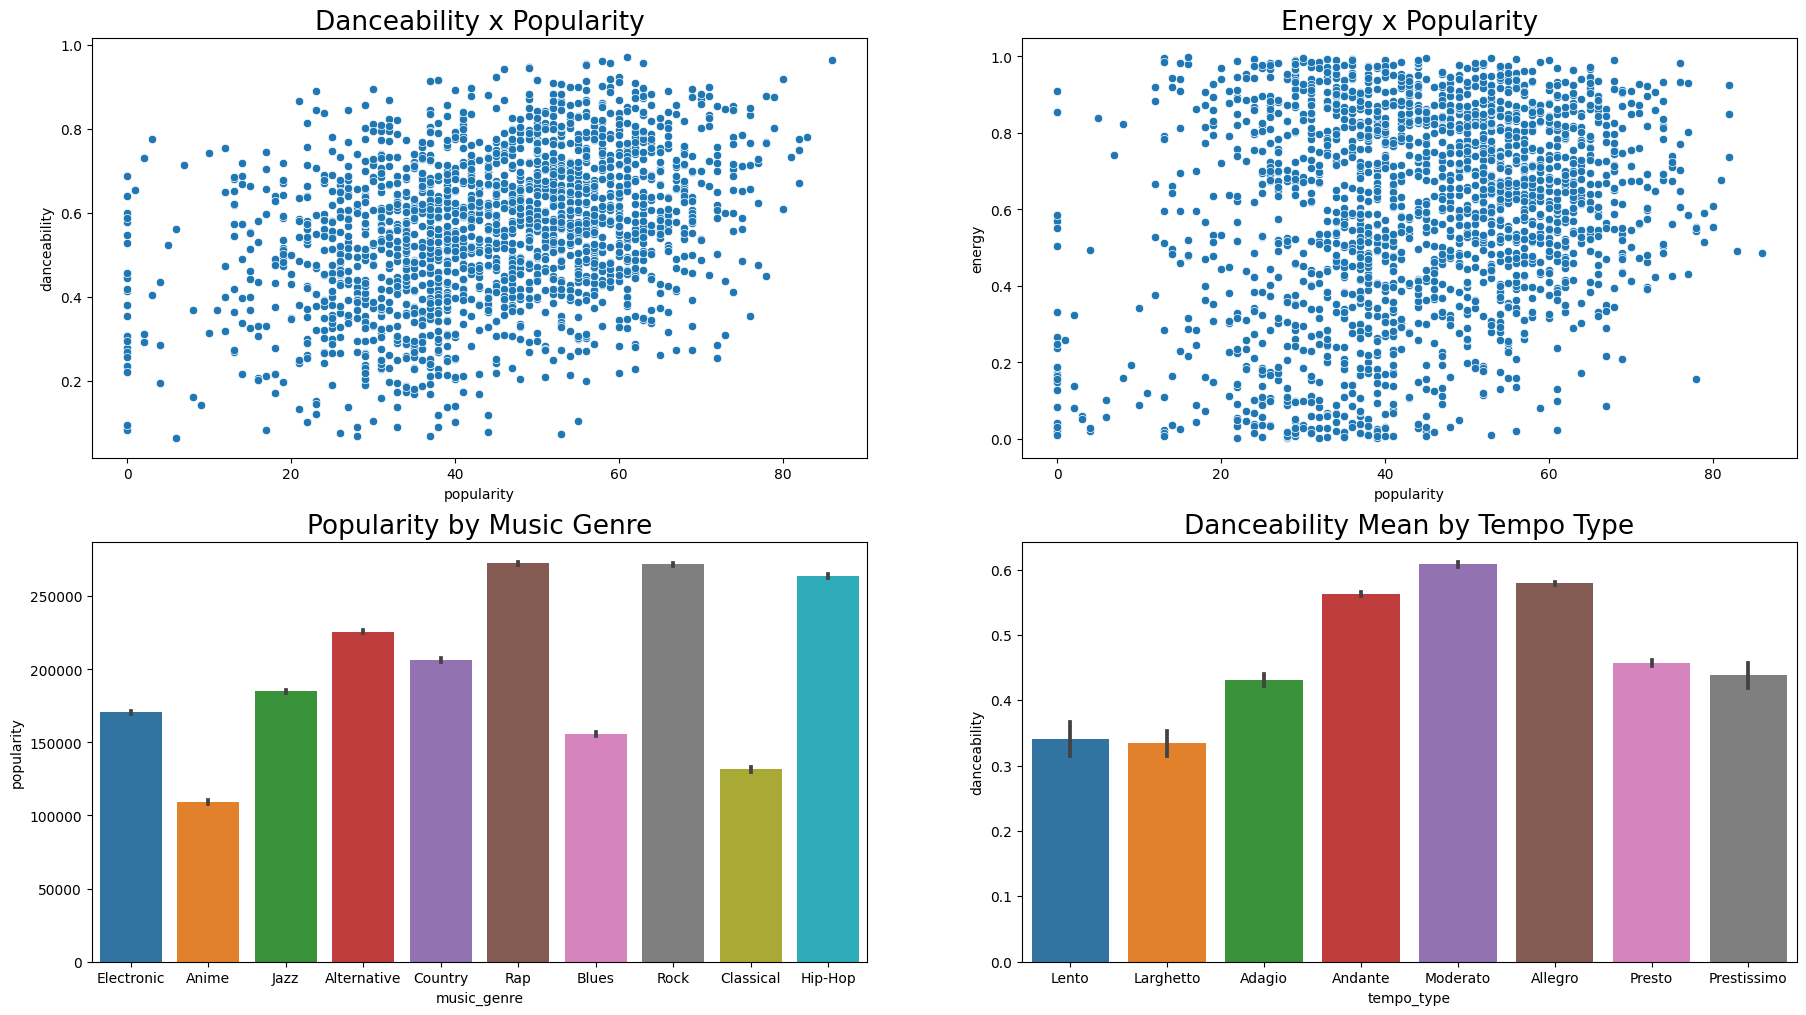

In [ ]:
# Gráficos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 12))
sns.scatterplot(x = df_norma_sample.popularity, y= df_norma_sample.danceability, ax= axes[0,0])
axes[0,0].set_title('Danceability x Popularity', fontsize= 19)
sns.barplot(data= df_normalized, x= 'tempo_type', y= 'danceability', estimator= np.mean, ax= axes[1,1])
axes[1,1].set_title('Danceability Mean by Tempo Type', fontsize= 19)
sns.barplot(data = df_normalized, x= 'music_genre', y= 'popularity', estimator= sum, ax= axes[1,0])
axes[1,0].set_title('Popularity by Music Genre', fontsize= 19)
sns.scatterplot(x = df_norma_sample.popularity, y= df_norma_sample.energy, ax= axes[0,1])
axes[0,1].set_title('Energy x Popularity', fontsize= 19)

Aqui podemos ver una agrupación de 4 gráficos, en la cual se nos presentan 2 gráficos de barras y 2 Scatterplots o también llamados diagramas de dispersión.
¿Que podemos ver en estos gráficos? A continuación haremos un pequeño de analísis de que nos cuentan estos gráficos y a que conlcusiones nos hacen llegar:
- Empecemos por el segundo gráfico 'Danceability Mean by Tempo Type'. Este es un gráfico de barras el cual nos muestra en el eje X los tipos de tempo y en el eje Y la bailabilidad. Podemos notar entonces que las canciones más bailables, suelen tener un tempo entre Andante, Moderato y/o Alegro, lo que quiere decir que el tempo de estas canciones oscila entre los 76 y 168 BPM (Beats Per Minute).
- Siguiendo con el otro gráfico de barras, esta vez encontramos en el eje X los distintos géneros músicales presentes en los datos, y en el eje Y, la popularidad. Podemos entender entonces que los géneros músicales que presentan una mayor cantidad de canciones populares son el Rap, el Rock y el Hip-Hop.
- Finalmente vemos los diagramas de dispersión, los cuales nos muestran tomando una muestra acotada de los datos, las distintas combinaciones entre la popularidad y la bailabilidad en un gráfico y la popularidad y la energia en el otro. Lamentablemente, no lograbos ver a simple vista un patrón claro entre estas 2 combinaciones de variables, lo cual nos indica que ni la energía ni la bailabilidad de una canción, está directamente relacionada con su popularidad, por lo que la popularidad de una canción se da a traves de una combinación de muchos factores.

Entonces, ¿Que preguntas nos respondimos hasta acá? Hasta este punto tenemos en claro:
- ¿Cuales son los tempos más bailables?
- ¿Cuales son los géneros músicales más populares?
- ¿Existe una relación directa entre la popularidad de las canciones y alguna de sus características, como la energía o la bailabilidad?

A continuación veremos 2 gráficos más, con los cuales nos podremos responder las siguientes preguntas:
- ¿Es más común ver canciones en una tonalidad Menor o Mayor?
- ¿De todas las notas músicales, en cual o cuales están basadas como nota tónica la mayoría de las canciones?

Text(0.5, 1.0, 'Key')

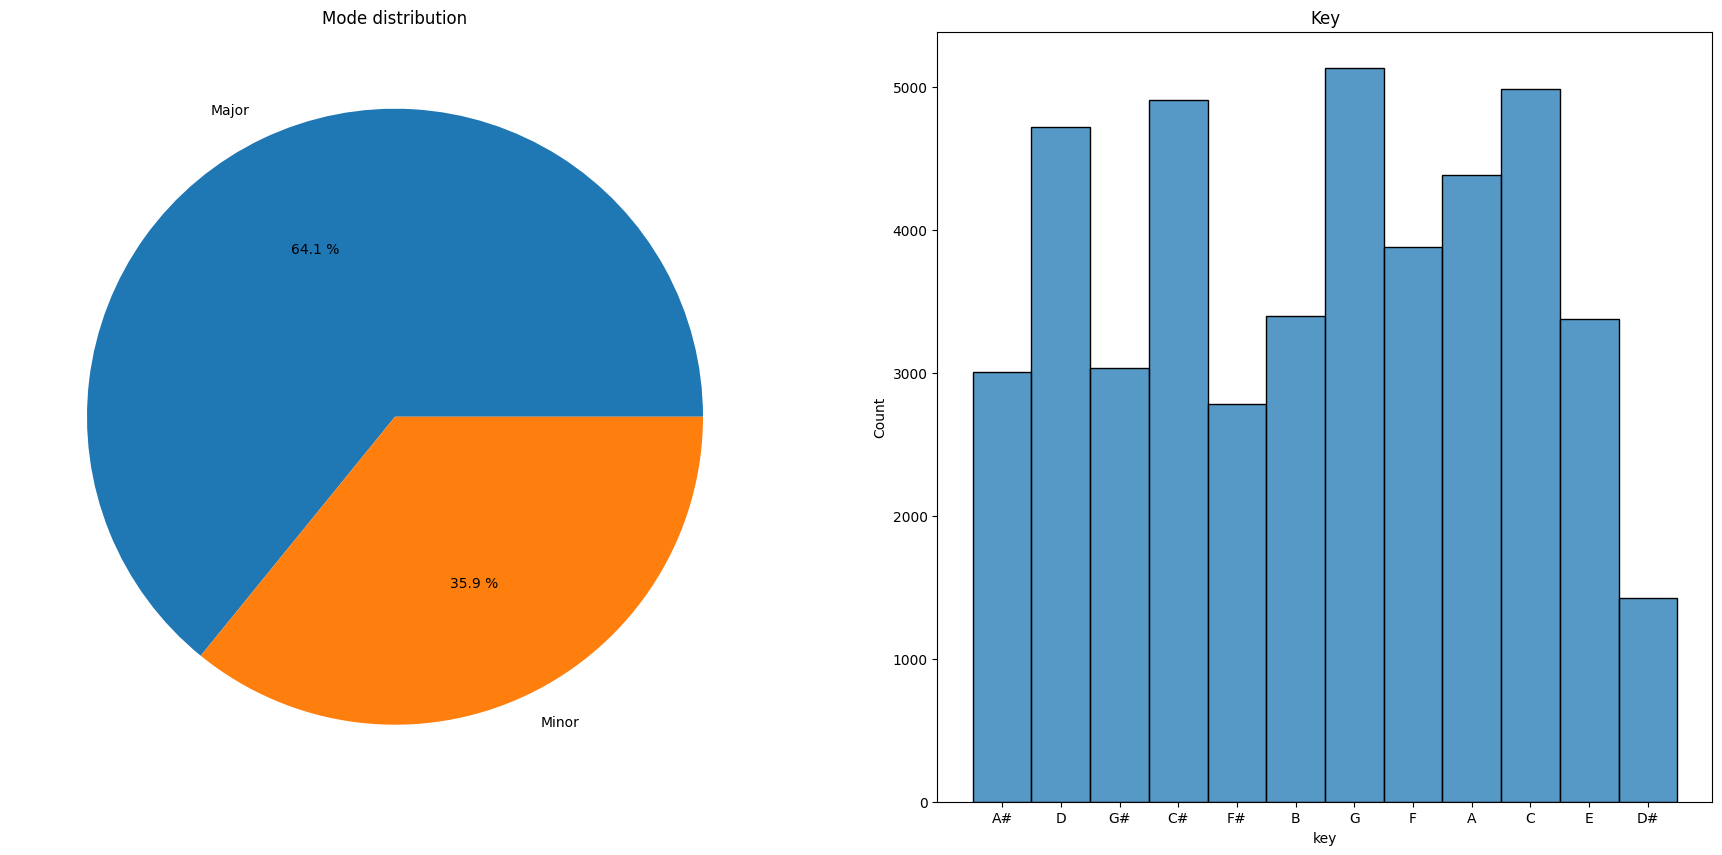

In [ ]:
# Más gráficos
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
mode_count = df_normalized['mode'].value_counts()
axes[0].pie(mode_count, labels= mode_count.index, autopct='%.1f %%')
axes[0].set_title('Mode distribution')
sns.histplot(ax= axes[1], data= df_normalized, x='key')
axes[1].set_title('Key')

Luego de ver estos gráficos podemos responder con seguridad las preguntas anteriormente planteadas:
- Sin dudas la tonalidad más usada es la Mayor
- Podemos notar a su vez que las notas más utilizadas como tónicas son Re (D), Do sostenido (C#), Sol (G) y Do (C)

Luego de este análisis de los 6 gráficos vistos, ahora conocemos un poco mejor los datos a los que nos enfrentamos y pudimos dar respuesta a ciertas preguntas, algunas que se formulaban en torno a nuestra variable objetivo, la popularidad de las canciones, y otras las cuales se centraban más en las distintas características que componen a la canción y que más adelante, mediante la implementación de Machine Learning, nos ayudaran a lograr nuestro gran objetivo, el cual es predecir en un rango confiable, la popularidad aproximada que puede alcanzar una canción.

In [ ]:
df_norma_sample.shape

(2000, 18)

In [ ]:
df_normalized.shape

(45020, 15)

In [ ]:
df.shape

(50005, 18)